# Weak Supervision Methods for Text Classification
Robert Helmeczi

rhelmeczi@ryerson.ca

# Introduction:

#### Problem Description:

In many contexts, access to an abundance of high-quality labeled data is not possible. In these settings, we require alternative methods to train models with access to little or no training data at all. In this project we discuss weak supervision, which refers to a branch of solution approaches that generate noisy or "weak" labels for a set of unlabeled data with access to either no expert-labeled data at all (zero-shot learning) or a small amount of labeled data (few-shot learning) [1, 2, 3].

#### Context of the Problem:

Training supervised learning models using labeled data can be prohibitively expensive [3]. Additionally, throughout the process of modeling it is often the case that data needs to be relabeled, necessitating additional overhead expenses to pay for labeled data [3]. These costs are sufficient to prevent many practitioners from pursuing standard supervised-learning techniques when training models [3]. These individuals often turn to weak supervision to solve their problem.

#### Limitation About other Approaches:

The main alternative to weak supervision is to use labeled data, whose limitations have been discussed. Another promising alternative to the weak supervision method discussed in this project is Snorkel, as introduced by Ratner et al. (2017). Snorkel is a weak supervision approach that aims to combine the noisy predictions of a large ensemble where the labels can be generated using crowdsourcing or via labeling functions [3]. This approach solves some of the problems associated with obtaining expertly labeled data, but it still requires writing labeling functions or obtaining crowdsourced labels.

#### Solution:

In this project we discuss pattern-exploiting training (PET), a semi-supervised learning method for generating labels for a large set of unlabeled data by fine-tuning pre-trained language models (PLMs) on a small set of labeled data [1]. In particular, PET uses masked language models (MLMs) in combination with user-defined cloze-style phrases which provide context to the problem [1, 2]. A cloze-style phrase is one where a token is masked. For example "This $\text{___}$ an example of a cloze-style phrase". Here, the masked token "$\text{___}$" is the word "is".

# Background

There are numerous methods for solving classification tasks in the few-shot setting. The following table discusses recent, popular approaches.

| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| Ratner et al. [3] | Few-shot learning by combining noisy labels generated using labeling functions and/or crowd-sourcing. | Various open-source datasets. | Requires access to unlabeled data and generation of labeling functions.
| Brown et al. [6] | Few-shot learning using GPT-3. | SuperGlue [4].| Requires immense compute power [2]. Large size makes deployment difficult [6].
| Schick et al. [1] | Few-shot learning using cloze-style phrases combined with a pretrained language model (PLM) and unlabeled data. | SuperGlue [4]. | Requires creation of cloze-style phrases and access to unlabeled data.

Observe that multiple papers use SuperGlue as their dataset. SuperGlue is a standardized benchmark released in 2019 used to evaluate NLP tasks [4]. The paper associated with its release, Wang et al. (2019), is referenced below.


# Methodology

PET is able to label data using the realization that, with a description of a problem, we can solve the problem much more easily even with just a small amount of labeled data [1]. For the purposes of this investigation, we consider the Yelp polarity dataset, where our objective is to label a review as either positive or negative. We consider access to only 40 labeled reviews, with an additional 2000 unlabeled reviews for training, and a set of 38000 reviews for testing.

There are three steps to solving a problem with PET:
1. Fine-tune a set of separate PLMs on the labeled training data, $\mathcal{T}$.
2. Use these models as an ensemble to predict labels for the unlabeled training data, $\mathcal{D}$.
3. Train a standard supervised learning classifier on $\mathcal{T}\cup\mathcal{D}$ with the newly predicted labels for $\mathcal{D}$.

Here, $\mathcal{T}$ is the set of 40 labeled reviews and $\mathcal{D}$ is the set of 2000 unlabeled reviews.

To solve Step 1, let's consider an example. This example is illustrated in Figure 1 below, from Schick and Schütze (2020a). Suppose we have a review from $\mathcal{T}$ as follows:

> Best pizza ever!

Now suppose its associated label is $+1$. We can train our PLM on this problem through the following process:

* Associate a word with each label. In this case, we'll associate "great" with the label $+1$, and "bad" with the label $-1$. This association is called a **verbalizer** [1].
* Concatenate a cloze-style phrase to the review. In this case, we'll use "It was ___." as our phrase. This is called a **pattern** [1]. Taken together, a **pattern** and **verbalizer** form a **pattern-verbalizer pair (PVP)**.


Now, the task for the PLM is to predict the masked token as either "great" or "bad" in the following string:

> Best pizza ever! It was ___.

The PLM will generate a probability for "great" and "bad". We have the label for this review: it is $+1$, meaning the correct prediction is "great". Given the prediction results from the PLM, we can fine-tune the weights to train the model to predict "great" for this review. In general, we can generate as many PVPs as we want and train a model for each one.

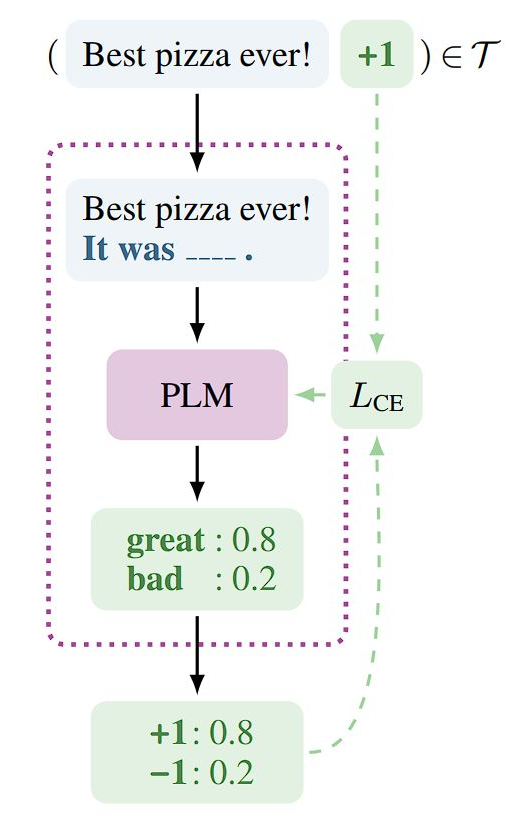

Figure 1: Training a PLM with a PVP.

In Figure 2, also taken from Schick and Schütze (2020a), we observe the review "Just gross." being passed to multiple boxes. Each of these boxes is a separate fine-tuned PLM that was trained using the method outlined in Step 1. Each model differs by the PVP used to fine-tune it.

Each of these models predicts a label for the review "Just gross.". There are several ways we may combine these predictions. The one we use in our implementation is to simply weight the prediction of each model by its accuracy on the training set, as described in Schick and Schütze (2020a). The objective in this case is to give a higher weight to models which are seemingly better predictors, but we note that this is susceptible to overtraining. This is a limitation of weak supervision: we have no means to determine which of the fine-tuned models performs the best. Ratner et al. (2019) discuss another method for combining the results of an ensemble of weak labels.

After Step 2 we have access to labels for all of our training data. The classifier trained in Step 3 can be any supervised classifier. In the paper for PET they fine-tune a sequence classifier, but in this project we will train a simple logistic regression classifier.

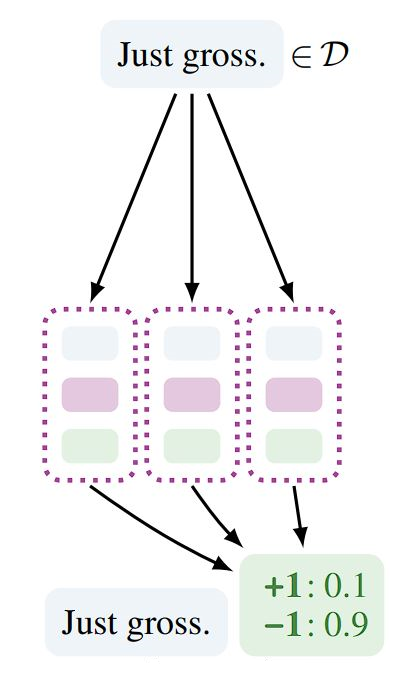

Figure 2: Combining multiple fine-tuned PLM predictions.

# Implementation

In [ ]:
# -q hides the output. Remove it if you encounter an error
!pip install -q transformers jsonpickle datasets;

In [ ]:
# mount the drive so we can access the data and source files
from google.colab import drive
drive.mount('/content/drive')

# set the below filepath to the location of the src files in your drive
# your folder is probably located somewhere within "/content/drive/My Drive/"
%cd "/content/drive/My Drive/PET/src"

Load in the data

In [ ]:
import helper_functions
import pet.modeling
import pet.wrapper
import pandas as pd
import numpy as np
label_list = np.array(['1', '2'])
df_train, df_unlabeled, df_test = helper_functions.get_yelp_polarity_data(
    show_progress_bars=False
)

Train our ensemble of models. This next code block completes all of Step 1.

In [ ]:
model_paths = helper_functions.train_models(
    [0, 1, 2],
    df_train['text'],
    df_train['label'],
    'yelp-polarity',
    label_list,
    output_dir='../trained_models'
)

Now, let's score these models on the training data. These scores give us our weights for combining the predictions on the unlabeled data.

In [ ]:
scores = helper_functions.score_models(
    model_paths, df_train['text'], df_train['label'], label_list
)

Next, get the predicted label probabilities for each of the unlabeled data by using the ensemble of models.

In [ ]:
unlabeled_probabilities = helper_functions.ensemble_predict(
    model_paths, scores, df_unlabeled['text']
)

Let's compute the accuracy of a logistic regression model on our test set by using just the 40 labeled data.

In [ ]:
helper_functions.train_and_score_logistic_regression_model(
    df_train['text'], df_train['label'], df_test['text'], df_test['label']
)

0.5786052631578947

Just 57.9%! Next, we'll combine the labeled training data with the unlabeled predictions and create another logistic regression model:

In [ ]:
helper_functions.train_and_score_logistic_regression_model(
    df_train['text'],
    df_train['label'],
    df_test['text'],
    df_test['label'],
    unlabeled_X_train=df_unlabeled['text'],
    unlabeled_probabilities=unlabeled_probabilities,
    label_list=label_list
)

0.8425263157894737

An accuracy of 84.3%! Just by using PVPs and PLMs, we were able to train a significantly better language model. Finally, let's see how well our models were able to predict the unlabeled data.

In [ ]:
helper_functions.score_predictions(
    df_unlabeled['label'], unlabeled_probabilities, label_list
)

0.96

An accuracy of 96%! This means that 96% of the 2000 unlabeled reviews had the correct prediction. Our ensemble of models is probably a better predictor than the logistic regression model, and we could try to use it on the test data. However, the logistic regression model is significantly faster than the ensemble of PLMs, so we do not use the ensemble as a predictor here.

# Conclusion and Future Direction

In this project we used PET for semi-supervised learning. It is surprising to see how accurate the ensemble of PLMs is at predicting the unlabeled data given access to so few labeled data. This clearly validates the performance of PET but, as we have discussed, there is no guarantee on this accuracy and, in a practical setting, we would not have access to it at all.

We also observed that combining the predictions of our ensemble can be susceptible to overtraining. Ratner et al. (2019) discuss other means for combining predictions, and clearly this is one of the tougher challenges in weak supervision: given a trained weak supervision model, how can we determine if it is a good predictor? Ratner et al. (2017) seek to address the problem at length in their paper, whereas in Schick and Schütze (2020a) this problem is addressed only by using weighted accuracies on the training data, a method that we have noted is susceptible to overtraining. In spite of this, Schick and Schütze (2020a) observe great results for many models, producing results competitive with supervised learning methods.




# References:

[1]:  Schick, T., and Schütze, H. (2020a). Exploiting cloze questions for few shot text classification and natural language inference. arXiv preprint arXiv:2001.07676.

[2]:  Schick, T., and Schütze, H. (2020b). It's not just size that matters: Small language models are also few-shot learners. arXiv preprint arXiv:2009.07118.

[3]: Ratner, A., Bach, S. H., Ehrenberg, H., Fries, J., Wu, S., and Ré, C. (2017). Snorkel: Rapid training data creation with weak supervision. In Proceedings of the VLDB Endowment. International Conference on Very Large Data Bases (Vol. 11, No. 3, p. 269). NIH Public Access.

[4]: Wang, A., Pruksachatkun, Y., Nangia, N., Singh, A., Michael, J., Hill, F., Bowman, S., et. al (2019). Superglue: A stickier benchmark for general-purpose language understanding systems. Advances in neural information processing systems, 32.

[5]: Ratner, A., Hancock, B., Dunnmon, J., Sala, F., Pandey, S., and Ré, C. (2019). Training complex models with multi-task weak supervision. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 33, No. 01, pp. 4763-4771).

[6]: Brown, T., Mann, B., Ryder, N., Subbiah, M., Kaplan, J. D., Dhariwal, P., ... and Amodei, D. (2020). Language models are few-shot learners. Advances in neural information processing systems, 33, 1877-1901.